![](https://i.imgur.com/sWyuy4Y.jpg)

In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
import logging

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [5]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [6]:
import os 
print(os.listdir("input"))

['Answers.csv', 'Questions.csv', 'Tags.csv', 'var']


In [7]:
# Importing the database 

df = pd.read_csv("input/Questions.csv", encoding="ISO-8859-1")

In [8]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [9]:
tags = pd.read_csv("input/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [10]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [13]:
tags['Tag'] = tags['Tag'].astype(str)

In [14]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [15]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [16]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [17]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [18]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [19]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [20]:
df = df.merge(grouped_tags_final, on='Id')

In [21]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [22]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

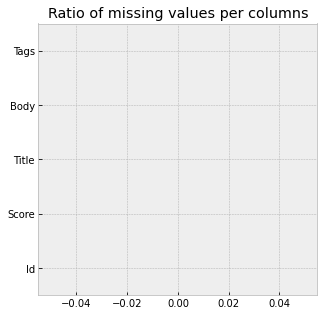

In [23]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [24]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [25]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [26]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [27]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [28]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [29]:
len(all_tags)

224129

In [30]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [31]:
new_df.shape

(72950, 3)

In [32]:
new_df.dropna(subset=['Tags'], inplace=True)

In [33]:
new_df.shape

(72950, 3)

We are here loosing 10000 rows but the it's for the greater good. 